In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
# Saving plots with editable text
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable text)

In [2]:
import dictys
from utils_custom import *
from pseudotime_curves import *
from episode_plots import *
from episodic_dynamics import *
from config import *

In [3]:
config = Config()

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/dynamic.h5')

# Fig 4 - Cell state distributions per fate

#### Get cell state labels for each window

In [5]:
cell_labels = pd.read_csv(config.CELL_LABELS, header=0)
display(cell_labels.index)

RangeIndex(start=0, stop=28494, step=1)

In [6]:
cell_assignment_matrix = dictys_dynamic_object.prop["sc"]["w"]
state_labels_in_window = {}
for window_idx in range(cell_assignment_matrix.shape[0]):
    indices_of_cells_present_in_window = np.where(
        cell_assignment_matrix[window_idx] == 1
        )[0] #these indices start from 0
    state_labels_in_window[window_idx] = [
        cell_labels.iloc[int(idx)]['Cluster'] for idx in indices_of_cells_present_in_window
        ]

In [7]:
state_count_per_window = window_labels_to_count_df(state_labels_in_window)
state_count_per_window = state_count_per_window.drop(index=['ActB-1', 'earlyActB'])

#### Always use pseudotime to bin windows instead of window indices - as pseudotime is the temporal spread/distribution and not the indices

In [8]:
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [9]:
# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}

In [14]:
pseudotime_values_of_windows = AlignTimeScales(dictys_dynamic_object, trajectory_range=[0, 2]).pseudotime_of_windows()

Time points per bin: [15, 17, 3, 3, 4, 3, 5, 1]
Total cells per bin: [np.float64(999.8), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0)]


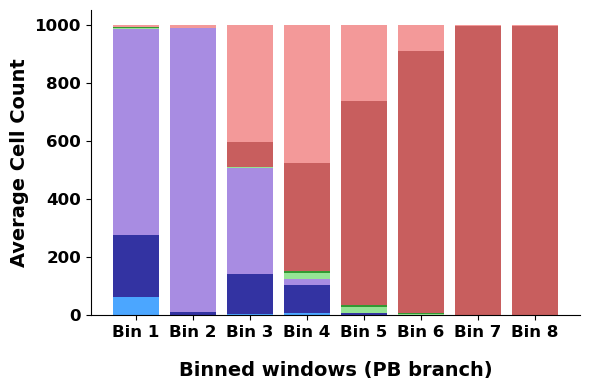

In [15]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = state_count_per_window[PB_post_bifurcation_window_indices]
# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save figure
#plt.savefig(os.path.join(output_folder, 'fig4_state_count_PB_bins.pdf'), dpi=1200)
#plt.show()
# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

# Pseudotime curves of TF expression and activity

In [15]:
exp_curves_dy, exp_curves_dx = SmoothedCurvesGRN(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="expression")

In [16]:
reg_curves_dy, reg_curves_dx = SmoothedCurvesGRN(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="regulation")

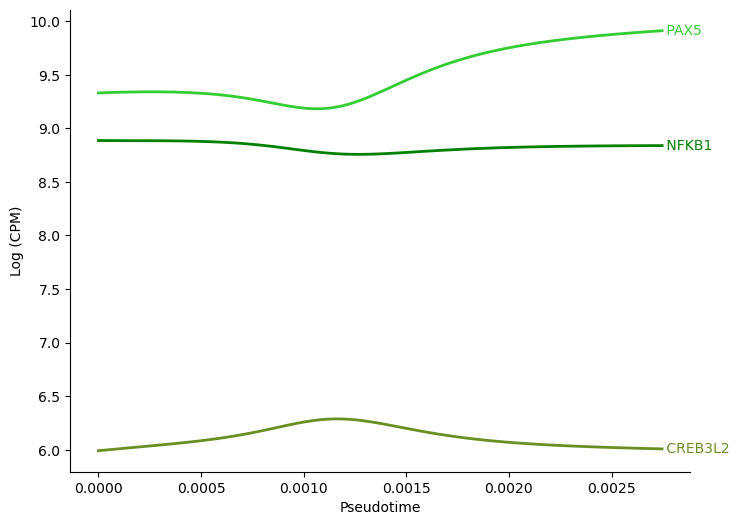

In [19]:
# Plot expression trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','BACH2']
#genes_of_interest_pb = ['TCF12','IRF4']
#genes_of_interest_pb = ['XBP1','PRDM1']
#genes_of_interest_gc = ['IRF4','BATF','PRDM1']
genes_of_interest_gc = ['PAX5','NFKB1','CREB3L2']
#genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
colors_gc = ['limegreen','green','olivedrab']
#colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in exp_curves_dy.index:
        line = plt.plot(exp_curves_dx, exp_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(exp_curves_dx.iloc[-1], exp_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (CPM)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'gc_2nd_wave_tfs_expression.pdf'), dpi=300)
plt.show()

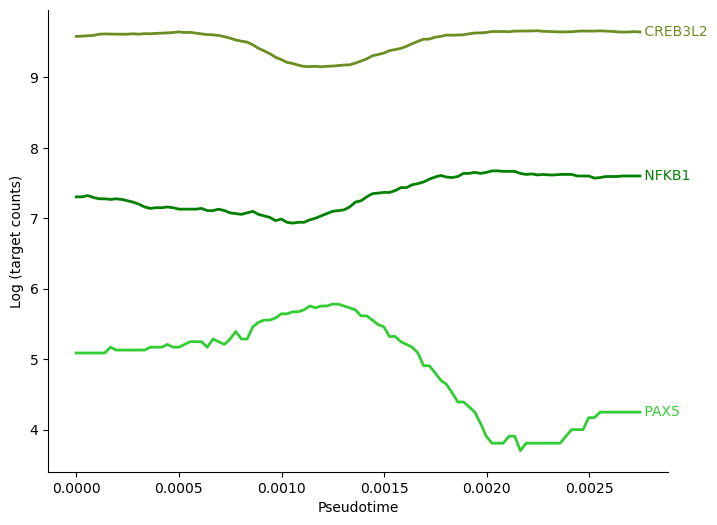

In [20]:
# Plot regulation trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in reg_curves_dy.index:
        line = plt.plot(reg_curves_dx, reg_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(reg_curves_dx.iloc[-1], reg_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (target counts)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'gc_2nd_wave_tfs_regulation.pdf'), dpi=300)
plt.show()

# Enriched links

In [5]:
PB_links_plotting = [('BACH2','XBP1'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('RUNX2','PRDM1'),('CREB3L2','MZB1'),('CREB3L2','RUNX2'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('IRF4','ELL2'),('XBP1','HSP90B1'),('XBP1','PPIB'),('XBP1','TXNDC11'),('PRDM1','IRF4'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [6]:

GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('BATF','PPIB'),('NFKB1','AFF3'),('IRF4','AFF3'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5'),('NFKB1','PAX5')]


#### Initialize pseudotime object

In [20]:
pseudotime_object = SmoothedCurvesGRN(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01)

In [21]:
beta_curves, dtime = pseudotime_object.get_beta_curves(GC_links_plotting, varname='w_in')

In [22]:
display(beta_curves)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                                
BACH2   PRDM1    0.007753  0.007704  0.007643  0.007568  0.007480  0.007376   
        PDE4D    0.000226  0.000223  0.000235  0.000264  0.000311  0.000380   
        MZB1     0.000426  0.000426  0.000424  0.000418  0.000410  0.000399   
        PAX5    -0.002576 -0.002610 -0.002645 -0.002681 -0.002718 -0.002755   
        AFF3    -0.003257 -0.003279 -0.003303 -0.003328 -0.003354 -0.003382   
        PIKFYVE -0.000122 -0.000130 -0.000135 -0.000140 -0.000141 -0.000141   
        PPIB    -0.000893 -0.000911 -0.000929 -0.000945 -0.000962 -0.000978   
        GLCCI1  -0.000392 -0.000438 -0.000483 -0.000526 -0.000568 -0.000609   
IRF4    PRDM1    0.002900  0.002962  0.003030  0.003103  0.003184  0.003272   
        PDE4D    0.002380  0.002419  0.002453  0.002483  0.002509  0.002532   
        MZB1    -0.002576 -0.002493 -0.002410 -0.002326 -0.002242 -0.002157   
        PAX5    -0.005944 -0.006012 -0.006085 -0.006165 -0.006252 -0.006347   
        AFF3    -0.001073 -0.000932 -0.000787 -0.000639 -0.000487 -0.000332   
        PIKFYVE -0.005272 -0.005350 -0.005429 -0.005511 -0.005597 -0.005685   
        PPIB    -0.004137 -0.004184 -0.004231 -0.004280 -0.004329 -0.004379   
        GLCCI1   0.033413  0.033845  0.034279  0.034712  0.035142  0.035567   
PAX5    PRDM1    0.004190  0.004224  0.004252  0.004274  0.004290  0.004300   
        PDE4D   -0.001325 -0.001345 -0.001365 -0.001385 -0.001405 -0.001424   
        MZB1     0.003850  0.003950  0.004051  0.004150  0.004249  0.004348   
        PAX5     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        AFF3    -0.000643 -0.000625 -0.000607 -0.000589 -0.000572 -0.000556   
        PIKFYVE  0.006452  0.006595  0.006734  0.006868  0.006994  0.007113   
        PPIB    -0.001996 -0.002149 -0.002301 -0.002453 -0.002605 -0.002756   
        GLCCI1  -0.002291 -0.002282 -0.002274 -0.002266 -0.002259 -0.002253   
BATF    PRDM1    0.003080  0.003074  0.003064  0.003050  0.003030  0.003005   
        PDE4D   -0.004072 -0.003905 -0.003735 -0.003562 -0.003387 -0.003209   
        MZB1    -0.002156 -0.002253 -0.002354 -0.002460 -0.002569 -0.002682   
        PAX5    -0.000196 -0.000156 -0.000117 -0.000080 -0.000044 -0.000009   
        AFF3    -0.005468 -0.005534 -0.005594 -0.005649 -0.005699 -0.005742   
        PIKFYVE  0.001900  0.001965  0.002027  0.002086  0.002142  0.002194   
        PPIB     0.001739  0.001704  0.001664  0.001619  0.001568  0.001511   
        GLCCI1   0.002678  0.002725  0.002773  0.002822  0.002871  0.002920   
CREB3L2 PRDM1   -0.020669 -0.021853 -0.023052 -0.024267 -0.025495 -0.026739   
        PDE4D    0.002477  0.002591  0.002697  0.002794  0.002882  0.002961   
        MZB1     0.003484  0.003133  0.002788  0.002451  0.002122  0.001800   
        PAX5    -0.003231 -0.003380 -0.003519 -0.003648 -0.003768 -0.003877   
        AFF3    -0.003606 -0.003491 -0.003373 -0.003251 -0.003125 -0.002996   
        PIKFYVE -0.005119 -0.005033 -0.004940 -0.004840 -0.004733 -0.004618   
        PPIB    -0.003547 -0.003667 -0.003783 -0.003896 -0.004005 -0.004112   
        GLCCI1  -0.001044 -0.001134 -0.001221 -0.001304 -0.001384 -0.001460   
ARID5B  PRDM1   -0.000271 -0.000298 -0.000321 -0.000340 -0.000356 -0.000368   
        PDE4D   -0.002633 -0.002706 -0.002777 -0.002847 -0.002915 -0.002981   
        MZB1     0.001301  0.001369  0.001438  0.001508  0.001577  0.001647   
        PAX5    -0.000500 -0.000523 -0.000547 -0.000573 -0.000599 -0.000626   
        AFF3    -0.002537 -0.002624 -0.002710 -0.002794 -0.002876 -0.002956   
        PIKFYVE -0.003273 -0.003341 -0.003403 -0.003461 -0.003514 -0.003562   
        PPIB     0.001679  0.001679  0.001680  0.001680  0.001680  0.001679   
        GLCCI1   0.002113  0.002148  0.002182  0.002215  0.002247  0.002278   
NFKB1   PRDM1   -0.005191 -0.005387 -0.005583 -0.005778 -0.005973 -0.

In [23]:
# get the expression curves of the TFs in the specified links
tf_expression, _ = pseudotime_object.get_smoothed_curves(mode='tf_expression')
regulon_tf_expression = tf_expression.loc[beta_curves.index.get_level_values(0).unique()]

In [24]:
force_curves = pseudotime_object.calculate_force_curves(beta_curves, regulon_tf_expression)

In [25]:
display(force_curves.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                               
BACH2 PRDM1   0.333455  0.332511  0.331330  0.329892  0.328171  0.326140   
      PDE4D   0.071832  0.071451  0.073087  0.076808  0.082493  0.089910   
      MZB1    0.094604  0.094596  0.094337  0.093813  0.093008  0.091895   
      PAX5   -0.206628 -0.207805 -0.208996 -0.210199 -0.211412 -0.212633   
      AFF3   -0.228814 -0.229466 -0.230155 -0.230880 -0.231643 -0.232446   

                time_6    time_7    time_8    time_9  ...   time_90   time_91  \
TF    Target                                          ...                       
BACH2 PRDM1   0.323765  0.321007  0.317821  0.314148  ...  0.297296  0.303482   
      PDE4D   0.098803  0.108944  0.120159  0.132319  ... -0.193990 -0.191842   
      MZB1    0.090438  0.088589  0.086283  0.083431  ... -0.197400 -0.197286   
      PAX5   -0.213861 -0.215093 -0.216330 -0.217571  ... -0.279549 -0.277920   
      AFF3   -0.233291 -0.234183 -0.235126 -0.236128  ... -0.308161 -0.305303   

               time_92   time_93   time_94   time_95   time_96   time_97  \
TF    Target                                                               
BACH2 PRDM1   0.309081  0.314161  0.318780  0.322986  0.326822  0.330325   
      PDE4D  -0.189569 -0.187184 -0.184695 -0.182111 -0.179438 -0.176681   
      MZB1   -0.197216 -0.197185 -0.197189 -0.197223 -0.197285 -0.197371   
      PAX5   -0.276374 -0.274909 -0.273524 -0.272215 -0.270982 -0.269821   
      AFF3   -0.302516 -0.299800 -0.297154 -0.294577 -0.292069 -0.289629   

               time_98   time_99  
TF    Target                      
BACH2 PRDM1   0.333529  0.336462  
      PDE4D  -0.173846 -0.170935  
      MZB1   -0.197477 -0.197600  
      PAX5   -0.268731 -0.267708  
      AFF3   -0.287255 -0.284947  

[5 rows x 100 columns]

#### Get max/soft-max timepoint per curve

In [26]:
import numpy as np
import pandas as pd

def get_max_points(force_curves, top_k=5, temperature=1.0):
    """
    Find pseudotime points with the highest absolute force values using softmax weighting.
    
    Parameters:
    -----------
    force_curves : DataFrame
        Multi-indexed DataFrame with (TF, Target) as rows and time points as columns
    top_k : int
        Number of top points to return per TF-Target pair
    temperature : float
        Temperature parameter for softmax (lower = more peaked distribution)
    
    Returns:
    --------
    list of dicts: Each containing TF, Target, pseudotime, force value, and softmax_weight
    """
    max_points = []
    
    # Get unique TF-Target pairs
    for tf_target in force_curves.index:
        # Get the time series for this TF-Target pair
        time_series = force_curves.loc[tf_target]
        # Get absolute force values
        abs_forces = time_series.abs()
        # Apply softmax to absolute forces
        softmax_weights = np.exp(abs_forces / temperature) / np.sum(np.exp(abs_forces / temperature))
        # Get top_k indices with highest softmax weights
        top_indices = softmax_weights.nlargest(top_k).index
        
        for time_col in top_indices:
            max_points.append({
                'TF': tf_target[0],
                'Target': tf_target[1],
                'pseudotime': time_col,
                'force': time_series[time_col],
                'abs_force': abs_forces[time_col],
                'softmax_weight': softmax_weights[time_col]
            })
    
    return max_points

In [27]:
# subset force curves to PB links
force_curves_plotting = force_curves.loc[GC_links_plotting]
max_points = get_max_points(force_curves_plotting, top_k=5, temperature=1.0)
display(max_points)

[{'TF': 'ARID5B',
  'Target': 'PIKFYVE',
  'pseudotime': 'time_12',
  'force': np.float64(-0.2328358431066743),
  'abs_force': np.float64(0.2328358431066743),
  'softmax_weight': np.float64(0.010773429983464929)},
 {'TF': 'ARID5B',
  'Target': 'PIKFYVE',
  'pseudotime': 'time_13',
  'force': np.float64(-0.2328242395567649),
  'abs_force': np.float64(0.2328242395567649),
  'softmax_weight': np.float64(0.010773304974157696)},
 {'TF': 'ARID5B',
  'Target': 'PIKFYVE',
  'pseudotime': 'time_11',
  'force': np.float64(-0.2326673513274172),
  'abs_force': np.float64(0.2326673513274172),
  'softmax_weight': np.float64(0.01077161490199576)},
 {'TF': 'ARID5B',
  'Target': 'PIKFYVE',
  'pseudotime': 'time_14',
  'force': np.float64(-0.23262715106702872),
  'abs_force': np.float64(0.23262715106702872),
  'softmax_weight': np.float64(0.010771181888975571)},
 {'TF': 'ARID5B',
  'Target': 'PIKFYVE',
  'pseudotime': 'time_10',
  'force': np.float64(-0.23232329179567568),
  'abs_force': np.float64(0.23

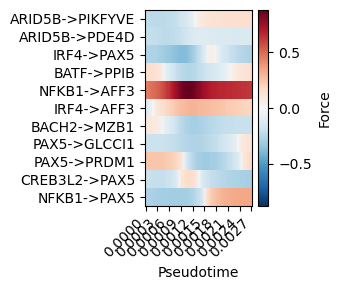

In [33]:
row_scaling = {
    ('NFKB1', 'AFF3'): 0.4  # Scale this GC link to x% of its original values
}

df_plot = force_curves.loc[GC_links_plotting]

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=df_plot,
    dtime=dtime,
    regulations=GC_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (3.5, 3),
    plot_figure=True,
    perform_clustering=False,
    row_scaling=None
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'enriched_links_GC_reordered.pdf'), 
#             bbox_inches='tight', 
#             dpi=300,
#             format='pdf')
plt.show()

# Fig 5/6 - Episodic enrichment plots
### Direct effect enrichment 

In [27]:
df_ep1 = pd.read_csv(config.ETS1_ALL['ep1'])
df_ep2 = pd.read_csv(config.ETS1_ALL['ep2'])
df_ep3 = pd.read_csv(config.ETS1_ALL['ep3'])
df_ep4 = pd.read_csv(config.ETS1_ALL['ep4'])
df_ep5 = pd.read_csv(config.ETS1_ALL['ep5'])
df_ep6 = pd.read_csv(config.ETS1_ALL['ep6'])
# df_ep7 = pd.read_csv(config.IKZF1_ALL['ep7'])
# df_ep8 = pd.read_csv(config.IKZF1_ALL['ep8'])

Filtered to 69 TFs that meet gene count criteria
Further filtered to 9 TFs that meet significance threshold < 0.004


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/src/multiome_dynamic_regulation/py_scripts/analysis/episode_plots.py:420: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


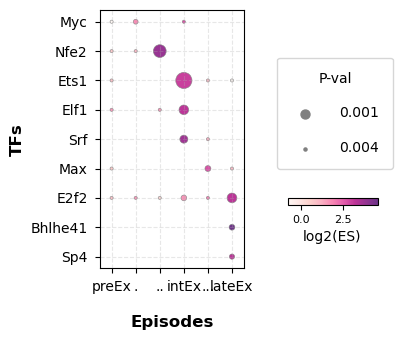

In [31]:
# TF order

#custom_tf_order_prdm1 = ['BPTF', 'SP1', 'BATF3', 'RBPJ', 'IKZF2']
#custom_tf_order_irf4 = ['MBD2', 'IKZF2', 'RBPJ', 'TCF12', 'BACH1', 'HMG20A']
#episode_labels=['ActB1/2', '.', '..', 'ActB3/4', '...', '....', '.....', 'lateGC']

# custom_tf_order_ets1_sig = ['Hdac2', 'Nfkb1', 'Ets1', 'Sin3a', 'Max']
#custom_tf_order_ikzf1_all = ['Ep300', 'E2f2', 'Klf6', 'Nfe2', 'Taf1', 'Nr4a2', 'Bhlhe40', 'Rad21', 'Klf2', 'Ctcf']
custom_tf_order_ets1_all = ['Myc', 'Nfe2', 'Ets1', 'Elf1', 'Srf', 'Max', 'E2f2', 'Bhlhe41', 'Sp4']
episode_labels=['preEx', '.', '..', 'intEx', '...', 'lateEx']

# custom_tf_order_z11_pb = ['CREB3L2', 'MEF2C', 'TFEC', 'TEAD2', 'IRF8', 'IRF9']
# custom_tf_order_z11_gc = ['IKZF3', 'USF2', 'IRF7', 'MEF2C', 'CDC5L', 'POU2F1']

# Use it in the plot
fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4, df_ep5, df_ep6],
    episode_labels=episode_labels,
    figsize=(4.5, 3.5), #breadth by length
    p_value_threshold=0.004,
    min_significance_threshold=0.004,
    min_dot_size=10,    
    max_dot_size=200,   
    cmap_name="RdPu",
    tf_order=custom_tf_order_ets1_all,
    figure_title=None,
    log_scale=True,
    horizontal_layout=False
)
# save the plot
fig.savefig(os.path.join(config.OUTPUT_FOLDER, "ets1_ee.pdf"), dpi=300)

# Ext. Fig 3 - Chromatin level TF activity over pseudotime

In [5]:
# list static and episodic TFs
static_tfs = ['PRDM1',
    'IRF4',
    'CREB3L2',
    'PAX5',
    'BATF',
    'BACH2']
episodic_tfs = ['IKZF2',
    'RBPJ',
    'NFATC2']
    
all_tfs = list(set(static_tfs + episodic_tfs))
base_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic'


In [25]:
smooth_chromatin_object = SmoothedCurvesChromatin(
    tfs=all_tfs,
    base_path=base_path
)

In [26]:
# Get pseudotime values for all windows
aligner = AlignTimeScales(
    dictys_dynamic_object=dictys_dynamic_object,
    trajectory_range=(1, 2),  # any trajectory starting from 1
    num_points=100,
    dist=0.0005,
    sparsity=0.01
)
window_pseudotimes = aligner.pseudotime_of_windows()

In [27]:
smooth_chromatin_object.set_trajectory_info(
    pb_indices=[1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2],
    gc_indices=[1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3],
    window_pseudotimes=window_pseudotimes
)

In [28]:
smooth_chromatin_object.extract_data(n_windows=194, n_processes=None)

Processing 194 windows using 127 processes...


Extracting Binding Data: 100%|██████████| 194/194 [00:02<00:00, 66.64it/s]


Extraction complete.


In [34]:
categories = {
    "Static": {
        "PRDM1": "#54278F",    # Dark purple
        "IRF4": "#756BB1",     # Purple
        "CREB3L2": "#9E9AC8",  # Medium purple
        "PAX5": "#BCBDDC",     # Light purple
        "BATF": "#DADAEB",     # Lighter purple
        "BACH2": "#EFEDF5"     # Lightest purple
    },
    "Episodic": {
        "IKZF2": "#D94701",    # Dark orange
        "RBPJ": "#F16913",     # Orange
        "NFATC2": "#FD8D3C"    # Light orange
    }
}

In [35]:
smooth_chromatin_object.process_dynamics(metric='score', smooth_sigma=2.0)
fig = smooth_chromatin_object.plot(categories=categories, y_label="TF Binding score", title=None)

# Save the figure as svg
fig.write_image(os.path.join(config.OUTPUT_FOLDER, "binding_score_all_tfs_ext_fig_3.svg"), format='svg')
fig.show()


In [36]:
smooth_chromatin_object.process_dynamics(metric='count', smooth_sigma=2.0)
fig = smooth_chromatin_object.plot(categories=categories, y_label="TF OCR count", title=None)

# Save the figure as svg
fig.write_image(os.path.join(config.OUTPUT_FOLDER, "ocr_count_all_tfs_ext_fig_3.svg"), format='svg')
fig.show()